## Data processing for statistical figures 

In [1]:
# imports
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from shapely.geometry import shape, Point


DATAFOLDER = 'data'
warnings.filterwarnings("ignore")

In [2]:
# read the .txt file and split the schedules by the separator '*Z '
with open(DATAFOLDER + "/2020_03_01/FPLAN") as schedules:
    text = schedules.read()
result = text.split('*Z ')

In [3]:
def int_list_time(a):
    l = []
    name = ''
    for i in a:
        if i.lstrip("-").isdigit():
            if len(i) == 5 or len(i) ==6:
                l.append(i)
        else:
            name += i
    return l, name           

In [4]:
# format the .txt file results
sch_number, route_number, transport_type, start_st_id, end_st_id, passing_st_ids, passing_st_names, st_arr_times, st_dep_times = ([] for i in range(9))
for i in result[1:]:    
    a = i.split('*')
    # get the identical information about schedule 
    schedule_id = a[0].split()
    route_number.append(schedule_id[0])
    sch_number.append(schedule_id[-2])
    # get the identical information about route 
    route_info = a[1].split()
    transport_type.append(route_info[1])
    start_st_id.append(route_info[2])
    end_st_id.append(route_info[3])
    st_id, station_name, arr_time, dep_time = ([] for i in range(4))
    # the route detail
    overall_sch = a[-1].split('%\n')[1:-1]
    for j in overall_sch:
        route = j.strip().split()
        st_id.append(route[0])
        time, station_name = int_list_time(route)
        arr_time.append(time[0])
        dep_time.append(time[-1])
    passing_st_ids.append(st_id)
    passing_st_names.append(station_name)
    st_arr_times.append(arr_time)
    st_dep_times.append(dep_time)

In [12]:
# making the dataframe from obtained lists 
data_dict = {'schedule_id': sch_number, 'route_number': route_number,'transport_type': transport_type,
            'start_station_ID': start_st_id,'end_station_ID': end_st_id, 'route_start_time': [time[0] for time in st_arr_times],
             'route_end_time': [time[-1] for time in st_dep_times],
            'passing_station_IDS': passing_st_ids,
            'passing_st_names': passing_st_names, 'arrival_times':st_arr_times, 'departure_times': st_dep_times}
data = pd.DataFrame.from_dict(data_dict)
# format the date
data.route_start_time = abs(data.route_start_time.astype(int)/100)%24
data.route_end_time = abs(data.route_end_time.astype(int)/100)%24
data.head()

,schedule_id,route_number,transport_type,start_station_ID,end_station_ID,route_start_time,route_end_time,passing_station_IDS,passing_st_names,arrival_times,departure_times
0,12607908707,04700,RE,8014309,8014228,4.47,5.40,"[8014309, 8014289, 8014288, 8014283, 8014281, ...",KarlsruheHbf,"[00447, 00452, 00456, 00501, 00506, 00513, 005...","[00447, 00453, 00457, 00502, 00507, 00514, 005..."
1,12606485457,04701,RE,8014228,8014309,4.56,5.41,"[8014228, 8014241, 8014245, 8014277, 8014281, ...",Offenburg,"[00456, 00505, 00509, 00515, 00521, 00526, 005...","[00456, 00505, 00510, 00516, 00522, 00527, 005..."
2,12605476307,04702,RE,8014309,8014228,5.46,6.39,"[8014309, 8014289, 8014288, 8014283, 8014281, ...",KarlsruheHbf,"[00546, 00550, 00555, 00559, 00604, 00611, 006...","[00546, 00551, 00555, 00600, 00605, 00612, 006..."
3,12611010807,04703,RE,8014521,8014586,5.51,7.25,"[8014521, 8014529, 8014533, 8014534, 8014554, ...",Konstanz,"[00551, 00601, 00609, 00615, 00632, 00635, 006...","[00551, 00602, 00610, 00619, 00633, 00636, 006..."
4,12610946707,04704,RE,8014521,8014228,5.35,7.50,"[8014521, 8014518, 8014513, 8014511, 8014502, ...",KarlsruheHbf,"[00535, 00543, 00557, 00611, 00619, 00625, 006...","[00535, 00544, 00558, 00612, 00621, 00626, 006..."


In [13]:
print("The number of available schedules until 2020 March 1st for a day in Switzerland: {}".format(data.shape[0]))

The number of available schedules until 2020 March 1st for a day in Switzerland: 473233


In [14]:
# map into several transport types 
trains = ['ICE', 'TGV', 'RJ', 'EC', 'IC', 'IR', 'PE', 'RE','EN', 'S','KB','BP','SN', 'R', 'ARZ', 'EXT', 'NJ', 'IRE','RJX', 'RB', 'CC','TER', 'BN']
fun = ['FUN', 'PB', 'SL']
metro = ['M']
bus = ['B', 'CAR', 'EXB','RUB']
ship = ['BAT', 'FAE']
tram = ['T', 'TE2']
gondola = ['GB', 'ASC']

data['transport_type'][data.transport_type.isin(trains)] = 'train'
data['transport_type'][data.transport_type.isin(fun)] = 'fun'
data['transport_type'][data.transport_type.isin(metro)] = 'metro'
data['transport_type'][data.transport_type.isin(bus)] = 'bus'
data['transport_type'][data.transport_type.isin(ship)] = 'ship'
data['transport_type'][data.transport_type.isin(tram)] = 'tram'
data['transport_type'][data.transport_type.isin(gondola)] = 'gondola'

In [15]:
data.shape

(473233, 11)

## Prepare data for Time Radial Histogram

In [16]:
time_data = data[["route_number", "transport_type", "route_start_time", "route_end_time"]]
print("The number of not-duplicated available schedules until 2020 March 1st for a day in Switzerland: {}".format(time_data.shape[0]))

The number of not-duplicated available schedules until 2020 March 1st for a day in Switzerland: 473233


In [17]:
def round_hour(hour, how_to = 'hourly'):
    int_hour = int(hour)
    mins = hour - int_hour
    if how_to == 'hourly':
        return int_hour
    if how_to == 'half_hourly':
        return round(int_hour + (0.3 if mins >= 0.3 else 0), 2)
    if how_to == 'quarter_hourly':
        return round(int_hour + (0.15 if mins >= 0.15 else 0) + (0.15 if mins >= 0.3 else 0)+ (0.15 if mins >= 0.45 else 0),2)

In [18]:
time_data['start_hourly'] = time_data.apply(lambda x: round_hour(x.route_start_time, 'hourly'), axis=1)
time_data['start_half_hourly'] = time_data.apply(lambda x: round_hour(x.route_start_time, 'half_hourly'), axis=1)
time_data['start_quarter_hourly'] = time_data.apply(lambda x: round_hour(x.route_start_time, 'quarter_hourly'), axis=1)

time_data['end_hourly'] = time_data.apply(lambda x: round_hour(x.route_end_time, 'hourly'), axis=1)
time_data['end_half_hourly'] = time_data.apply(lambda x: round_hour(x.route_end_time, 'half_hourly'), axis=1)
time_data['end_quarter_hourly'] = time_data.apply(lambda x: round_hour(x.route_end_time, 'quarter_hourly'), axis=1)

In [19]:
def get_data(time_var = 'hourly'):
    s = time_data.groupby(['start_{}'.format(time_var)]).size().reset_index(name = 'starting')
    e = time_data.groupby(['end_{}'.format(time_var)]).size().reset_index(name = 'ending')
    t_data = pd.merge(s, e, how='left', left_on= 'start_{}'.format(time_var), right_on = 'end_{}'.format(time_var))[['start_{}'.format(time_var), 'starting', 'ending']]
    t_data.rename(columns={'start_{}'.format(time_var): 'time'}, inplace=True)
    return t_data

In [20]:
get_data(time_var = 'hourly').to_csv(DATAFOLDER +'/data_figures/hourly_start_end.csv', index=False)
get_data(time_var = 'half_hourly').to_csv(DATAFOLDER +'/data_figures/half_hourly_start_end.csv', index=False)
get_data(time_var = 'quarter_hourly').to_csv(DATAFOLDER +'/data_figures/quarter_hourly_start_end.csv', index=False)

In [26]:
example = get_data(time_var = 'half_hourly')

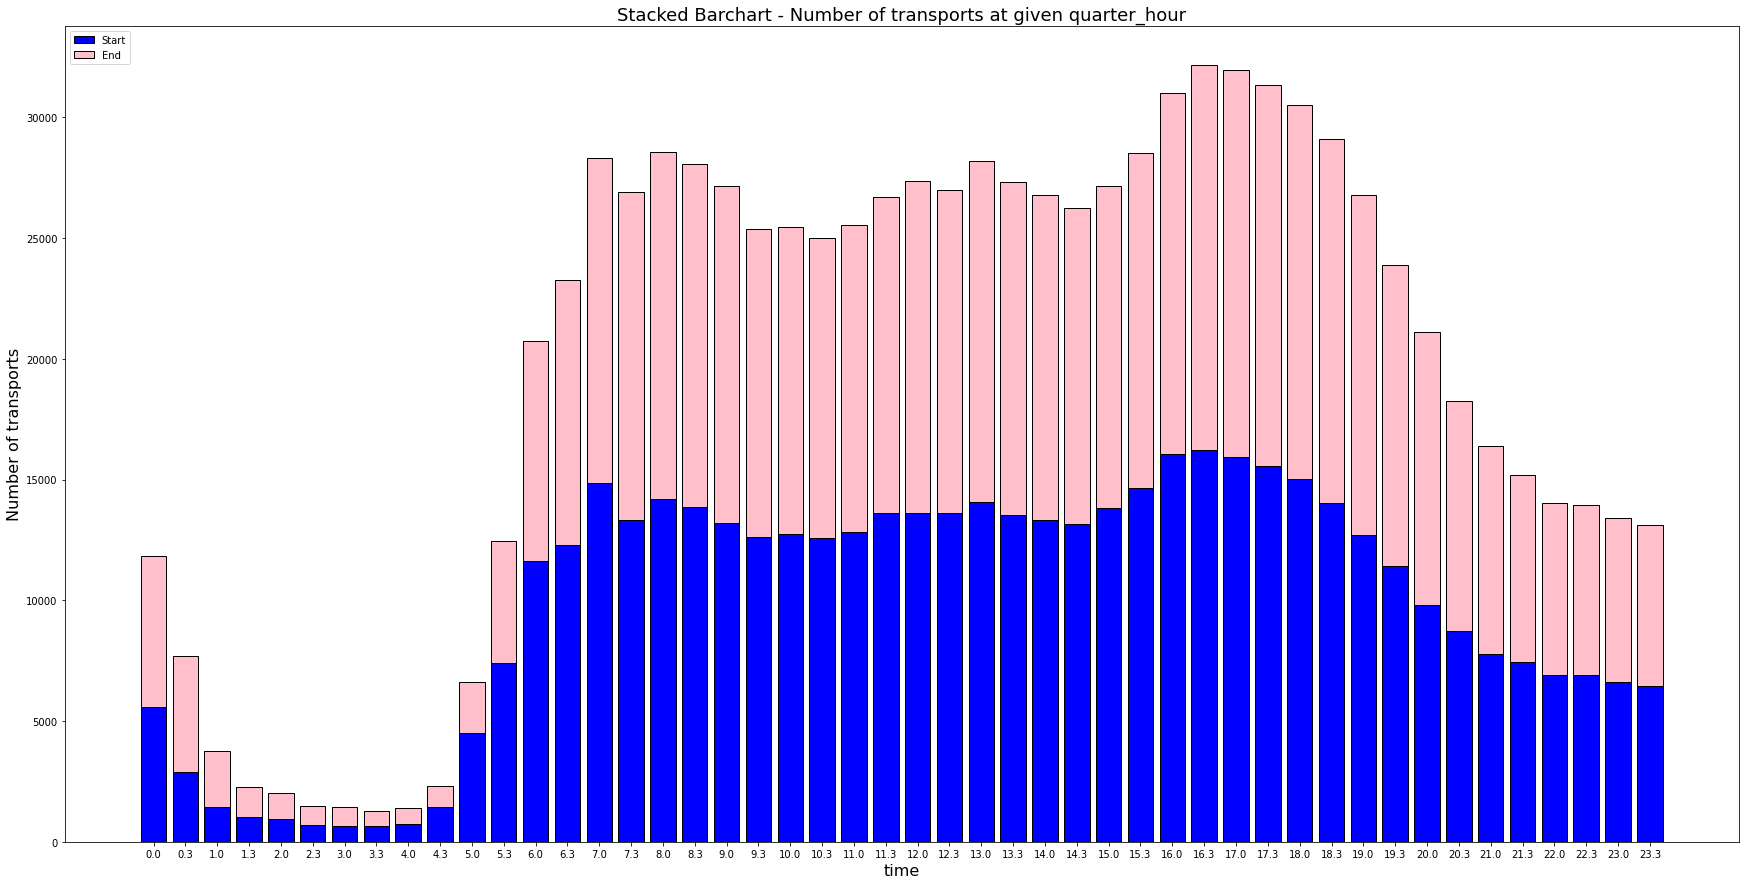

In [27]:
#plot an example
time=example.time.tolist()
classs=['Start','End']
pos = np.arange(example.shape[0])
starting_number=example.starting.tolist()
ending_number=example.ending.tolist()
 
plt.rcParams["figure.figsize"] = (30,15)

plt.bar(pos,starting_number,color='blue',edgecolor='black')
plt.bar(pos,ending_number,color='pink',edgecolor='black',bottom=starting_number)
plt.xticks(pos, time)
plt.xlabel('time', fontsize=16)
plt.ylabel('Number of transports', fontsize=16)
plt.title('Stacked Barchart - Number of transports at given quarter_hour',fontsize=18)
plt.legend(classs,loc=2)
plt.show()

## Prepare the data for Bubble graph

In [28]:
tr_types = ['train','fun','metro','ship','tram', 'gondola'] # - bus

In [29]:
# load GeoJSON file containing sectors
with open(DATAFOLDER + '/dd_geojson_switzerland.json') as f:
    js = json.load(f)
    
# construct point based on lon/lat returned by geocoder
def get_canton(js, lat, long):
    point = Point(lat, long)
   # check each polygon to see if it contains the point
    for feature in js['features']:
        polygon = shape(feature['geometry'])
        if polygon.contains(point):
            return feature['properties']['name']
    return 'not in switzerland'
get_canton(js, 7.655224, 47.597713)

'not in switzerland'

In [30]:
tr_res = data[['start_station_ID','end_station_ID', 'transport_type','passing_station_IDS' ]]
# take all the transport types except buses
tr_res = tr_res[tr_res.transport_type.isin(tr_types)]

In [33]:
def create_unique_station_type(tr_res,tr_types):
    data = {}
    for type_ in tr_types:
        tr = tr_res[tr_res.transport_type == type_].passing_station_IDS.tolist()
        tr_set = {'800000'}
        for i in range(len(tr)):
            tr_set.update(tr[i])
        res = dict.fromkeys(tr_set, type_) 
        data.update(res)
    return data

In [34]:
tr_res = pd.DataFrame(create_unique_station_type(tr_res,tr_types).items(), columns= ['station_id', 'transport_type'])

Text(0.5, 0, 'Number of schedules for different route types')

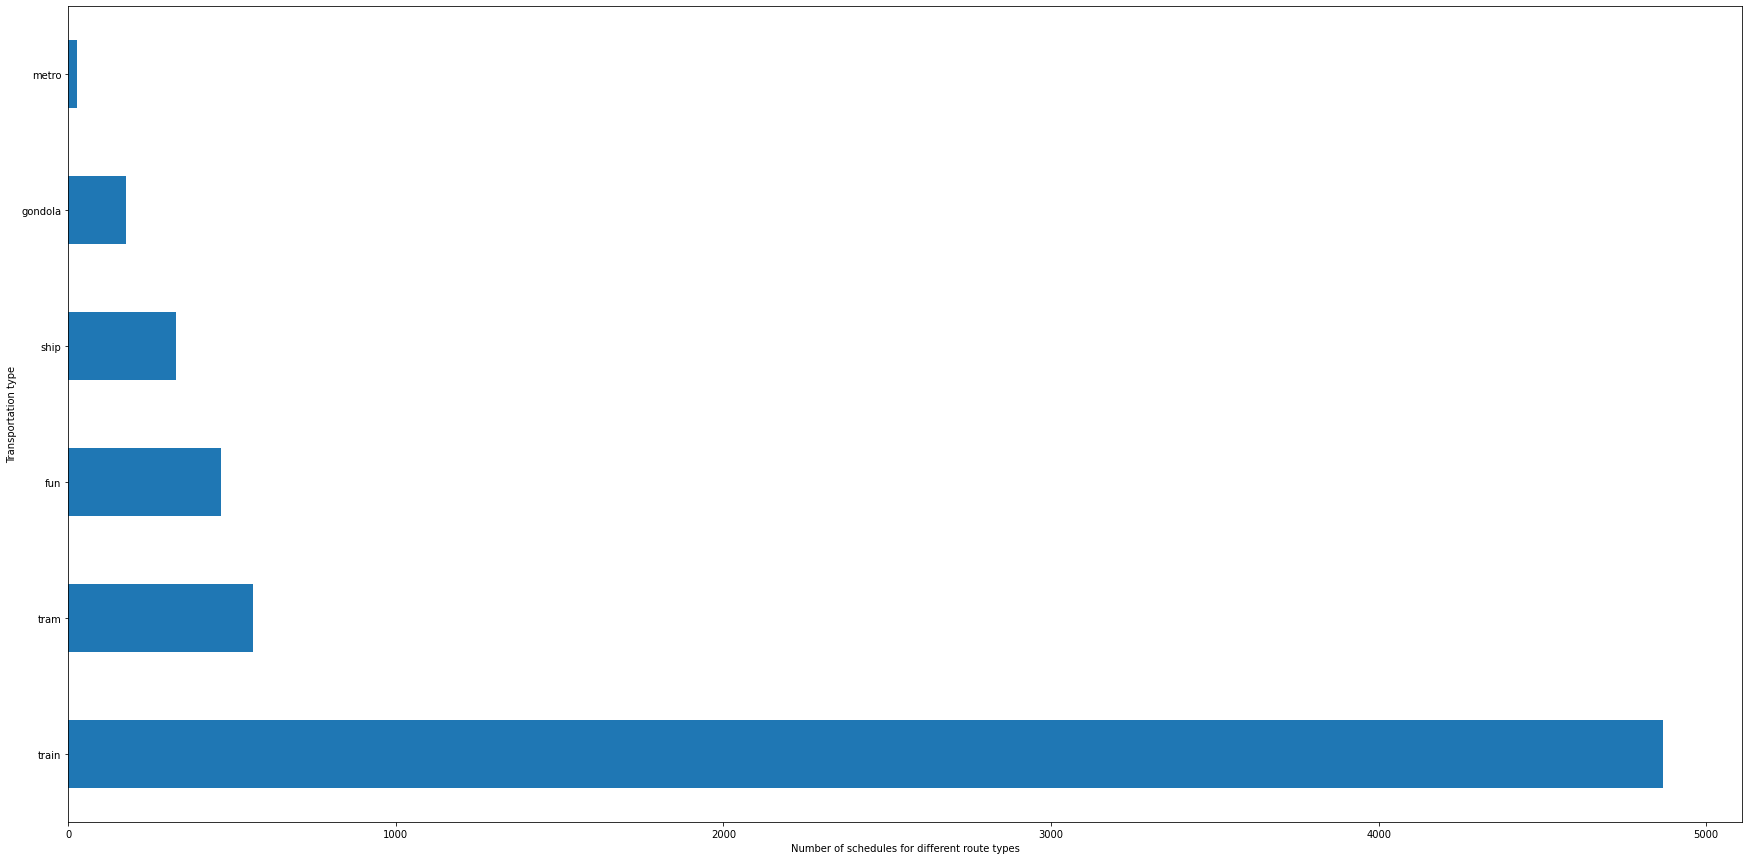

In [35]:
ax = tr_res.transport_type.value_counts()[:10].plot.barh(legend=False)
ax.set_ylabel('Transportation type')
ax.set_xlabel('Number of schedules for different route types')

In [36]:
tr_res.transport_type.value_counts()

train      4867
tram        563
fun         465
ship        330
gondola     177
metro        28
Name: transport_type, dtype: int64

In [48]:
with open(DATAFOLDER + "/2020_03_01/BFKOORD_GEO") as stations:
    text = stations.read()
result = text.split('\n')
st_id, lat, longt, number, name = ([] for i in range(5))
for i in range(len(result) - 1):
    each = result[i].split()
    st_id.append(each[0])
    longt.append(each[1])
    lat.append(each[2])
    number.append(each[3])
    name.append(' '.join(each[5:])) 
station_info = {'station_id': st_id, 'latitude': lat,'longitude': longt
               ,'number': number,'station_name': name}
stations = pd.DataFrame.from_dict(station_info)

stations.latitude= stations.latitude.astype(float)
stations.longitude= stations.longitude.astype(float)

In [49]:
with open(DATAFOLDER + '/dd_geojson_switzerland.json') as f:
    js = json.load(f)
    
# construct point based on lon/lat returned by geocoder
def get_canton(js, lat, long):
    point = Point(long, lat)
   # check each polygon to see if it contains the point
    for feature in js['features']:
        polygon = shape(feature['geometry'])
        if polygon.contains(point):
            return feature['properties']['name']
    return 'not in switzerland'

In [50]:
stations['canton'] = stations.apply(lambda row: get_canton(js, row.latitude, row.longitude), axis = 1)

In [51]:
suisse_stations = stations[stations.canton != 'not in switzerland']

In [53]:
suisse_stations.head()

,station_id,latitude,longitude,number,station_name,canton
6,0000011,47.191698,7.389618,466,Grenchen,Solothurn
10,0000022,47.547412,7.589562,276,Basel,Basel-Stadt
11,0000024,46.937487,7.395237,561,Bern Bümpliz,Bern/Berne
24,0000059,47.659615,9.132979,403,Tägerwilen,Thurgau
29,0000085,47.018942,7.498927,527,Schönbühl,Bern/Berne


In [54]:
station_name_id_map = pd.merge(tr_res, suisse_stations, how='inner', left_on='station_id', right_on='station_id')

In [55]:
print(tr_res.shape)
print(station_name_id_map.shape)

(6430, 2)
(5775, 7)


In [56]:
canton_tt_data = station_name_id_map.groupby(['canton', 'transport_type']).size().reset_index(name='counts')

In [57]:
canton_tt_data[canton_tt_data.canton == 'Vaud']

,canton,transport_type,counts
74,Vaud,fun,16
75,Vaud,gondola,10
76,Vaud,metro,28
77,Vaud,ship,29
78,Vaud,train,274


In [58]:
a = []
canton_names = canton_tt_data.canton.unique().tolist()
for i in canton_names:
    children = {}
    l = []
    children['name'] = i
    for j in canton_tt_data[canton_tt_data.canton == i].transport_type.tolist():
        children_2 = {}
        children_2['name'] = j
        children_2['size'] = canton_tt_data[(canton_tt_data.canton == i) & (canton_tt_data.transport_type == j)].counts.tolist()[0]
        l.append(children_2)
        
    children['children'] = l
    a.append(children)
bubble = {"name": "Canton_tt", 'children': a}

In [59]:
bubble

{'name': 'Canton_tt',
 'children': [{'name': 'Aargau',
   'children': [{'name': 'ship', 'size': 6}, {'name': 'train', 'size': 185}]},
  {'name': 'Appenzell Ausserrhoden',
   'children': [{'name': 'fun', 'size': 2}, {'name': 'train', 'size': 42}]},
  {'name': 'Appenzell Innerrhoden',
   'children': [{'name': 'fun', 'size': 5}, {'name': 'train', 'size': 10}]},
  {'name': 'Basel-Landschaft',
   'children': [{'name': 'gondola', 'size': 2},
    {'name': 'train', 'size': 21},
    {'name': 'tram', 'size': 78}]},
  {'name': 'Basel-Stadt',
   'children': [{'name': 'train', 'size': 8}, {'name': 'tram', 'size': 116}]},
  {'name': 'Bern/Berne',
   'children': [{'name': 'fun', 'size': 69},
    {'name': 'gondola', 'size': 33},
    {'name': 'ship', 'size': 36},
    {'name': 'train', 'size': 887},
    {'name': 'tram', 'size': 71}]},
  {'name': 'Fribourg',
   'children': [{'name': 'fun', 'size': 7},
    {'name': 'ship', 'size': 7},
    {'name': 'train', 'size': 350}]},
  {'name': 'Genève',
   'children

In [60]:
with open('githubio_web/data' + '/bubble.json', 'w') as fp:
    json.dump(bubble, fp)

## Prepare the data for D3. force

In [61]:
df = pd.read_excel(DATAFOLDER +'/passengers2018.xlsx')

# get the size of the data set
print("The data contains passenger capacity information for {} stations in Switzerland.".format(df.shape[0]))
# get some sample of the data
df.head()

The data contains passenger capacity information for 906 stations in Switzerland.


,Code,Bahnhof_Haltestelle,Kanton,Eigner,DTV_2018,DWV_2018,DNWV_2018,Bemerkungen,Remarques,Note,Remarks
0,AA,Aarau,AG,SBB,37900,44800,22700,Ohne AVA.,Sans AVA.,Senza AVA.,Without AVA.
1,AAT,Aathal,ZH,SBB,740,800,610,NaN,NaN,NaN,NaN
2,ABO,Aarburg-Oftringen,AG,SBB,2500,3000,1300,NaN,NaN,NaN,NaN
3,ACLA,Acla da Fontauna,GR,MGB,90,90,80,NaN,NaN,NaN,NaN
4,AD,Aadorf,TG,SBB,1700,2000,1000,Durchschnittswert 2018 durch Streckensperrung ...,Valeur moyenne 2018 à la baisse en raison de l...,Valore medio 2018 compromesso dallo sbarrament...,Average value for 2018 impacted by line closure.


In [62]:
df_p = df.fillna(value=0)
df_p = df_p.rename(columns = {'Code':'station_code','Bahnhof_Haltestelle':'station_name', 'Kanton':'canton','DNWV_2018': 'capacity'})
big_stations = df_p[['station_code', 'station_name', 'canton', 'capacity']]

big_stations['capacity'] = big_stations['capacity'].replace('<50','49')
#change the type of value in the data set
big_stations['capacity'] = big_stations['capacity'].astype('int')

In [64]:
big_stations = big_stations.sort_values('capacity', ascending = False).head(300)[['station_code', 'station_name', 'canton']]


In [68]:
stations1 = pd.merge(big_stations, stations, how = "left", on = 'station_name')
stations1 = stations1[["station_code","station_name","canton_y","latitude","longitude"]]

In [69]:
stations1.head()

,station_code,station_name,canton_y,latitude,longitude
0,ZUE,Zürich HB,Zürich,47.378177,8.540212
1,BN,Bern,Bern/Berne,46.948832,7.439130
2,LZ,Luzern,Luzern,47.050178,8.310183
3,BS,Basel SBB,Basel-Stadt,47.547412,7.589562
4,W,Winterthur,Zürich,47.500334,8.723820


In [71]:
def create_links(passing_st_ids):
    """Create the dict of links with frequency values"""
    links = []
    info = {}
    for i in range(len(passing_st_ids)):
        sorted_ids = sorted(passing_st_ids[i]) 
        for j in range(len(sorted_ids)):
            for k in range(j+1, len(sorted_ids)):
                info = {}
                info['source'] = sorted_ids[j]
                info['target'] = sorted_ids[k]
                info['value'] = 1
                links.append(info)
    return links
#links = create_links(passing_st_ids)
#a = pd.DataFrame.from_dict(links)
#d = a.groupby(['source','target'])['value'].sum().reset_index()

In [72]:
links = pd.read_csv(DATAFOLDER + '/data_figures/links.csv')

In [74]:
nodes = pd.merge(big_stations, stations, how='inner', left_on = 'station_name', right_on = 'station_name')
nodes = nodes[['station_code','canton_y', 'station_id']]
nodes.station_id = nodes.station_id.astype(int)

In [75]:
a = pd.merge(links, nodes, how ='inner', left_on = 'source', right_on = 'station_id')[['station_code','source','target', 'value' ]]
b = pd.merge(a,nodes, how ='inner', left_on = 'target', right_on = 'station_id' )

In [77]:
trips = b[['station_code_x','station_code_y','value']]
trips.rename(columns={'station_code_x': 'origin', 'station_code_y': 'destination', 'value':'count'}, inplace=True)
stations1.rename(columns={'station_code': 'iata', 'station_name': 'name', 'canton_y': 'canton'}, inplace=True)
stations1.to_csv(DATAFOLDER +'/data_figures/stations.csv', index=False)
trips.to_csv(DATAFOLDER +'/data_figures/trips.csv', index = False)

## Scripts for Force graph be careful while running

In [584]:
nodes['station_Id_int'] = nodes.apply(lambda x: int(x['station_id']), axis = 1).tolist()

In [587]:
c = b.source.tolist() + b.target.tolist()

In [588]:
nodes = nodes[nodes['station_Id_int'].isin(c)]

In [589]:
link = b[['station_name_x', 'station_name_y', 'value']]

In [590]:
link.rename(columns={'station_name_x': 'source', 'station_name_y' : 'target'}, inplace = True)

In [591]:
canton_map = {}
cantons = nodes.canton_x.unique()
for i in range(len(cantons)):
    canton_map.update({cantons[i] : i})

In [592]:
# scale the edge weight
link.value  = round(link.value.divide(100)).astype(int)
link.head()

,source,target,value
0,Basel SBB,Liestal,4
1,Basel SBB,Olten,5
2,Liestal,Olten,3
3,Solothurn,Olten,3
4,Basel SBB,Brugg AG,2


In [593]:
nodes['group'] = nodes.apply(lambda x: canton_map[x.canton_x], axis = 1)

In [594]:
nodes.rename(columns={'station_name': 'id'}, inplace = True)

In [597]:
n = nodes[['id', 'group']].to_dict('records')
l = link.to_dict('records')

In [598]:
force = {}
force['nodes'] = n
force['links'] = l

In [599]:
force

{'nodes': [{'id': 'Zürich HB', 'group': 0},
  {'id': 'Bern', 'group': 1},
  {'id': 'Luzern', 'group': 2},
  {'id': 'Basel SBB', 'group': 3},
  {'id': 'Winterthur', 'group': 0},
  {'id': 'Lausanne', 'group': 4},
  {'id': 'Olten', 'group': 5},
  {'id': 'Zürich Oerlikon', 'group': 0},
  {'id': 'Zürich Flughafen', 'group': 0},
  {'id': 'Zürich Stadelhofen', 'group': 0},
  {'id': 'Genève', 'group': 6},
  {'id': 'Biel/Bienne', 'group': 1},
  {'id': 'St. Gallen', 'group': 7},
  {'id': 'Zürich Hardbrücke', 'group': 0},
  {'id': 'Thun', 'group': 1},
  {'id': 'Zug', 'group': 8},
  {'id': 'Chur', 'group': 9},
  {'id': 'Aarau', 'group': 10},
  {'id': 'Visp', 'group': 11},
  {'id': 'Baden', 'group': 10},
  {'id': 'Neuchâtel', 'group': 12},
  {'id': 'Rapperswil', 'group': 7},
  {'id': 'Zürich Altstetten', 'group': 0},
  {'id': 'Brig', 'group': 11},
  {'id': 'Lenzburg', 'group': 10},
  {'id': 'Genève-Aéroport', 'group': 6},
  {'id': 'Wetzikon', 'group': 0},
  {'id': 'Uster', 'group': 0},
  {'id': 'La

In [600]:
import json
with open('githubio_web/data' + '/force.json', 'w') as fp:
    json.dump(force, fp)